# Validación de Features para ITG Stamina

Este cuaderno valida el pipeline de parseo y extracción de features para charts de stamina en ITG. Carga un archivo `.sm` de ejemplo, visualiza la densidad de notas por compás, deriva secuencias de stream/break y formatea texto de breakdown y métricas como evidencia para la tesis. Los gráficos usan Matplotlib (línea de notas por compás) y las funciones de `parser`/`features` se importan ajustando `sys.path` hacia `src`.

In [1]:
%reload_ext autoreload

In [2]:
# Imports
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import PolyCollection
from pathlib import Path
import sys
from pprint import pprint
import matplotlib.pyplot as plt

In [3]:
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "notebooks" else NOTEBOOK_DIR
SRC_PATH = PROJECT_ROOT / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

print(f"Notebook directory: {NOTEBOOK_DIR}")
print(f"Project root: {PROJECT_ROOT}")
print(f"SRC path added: {SRC_PATH}")

Notebook directory: /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core/notebooks
Project root: /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core
SRC path added: /home/maru/Documents/Tesina/ITGStamina-rater-ml/ml-core/src


Loaded 137 measures from lovism.sm


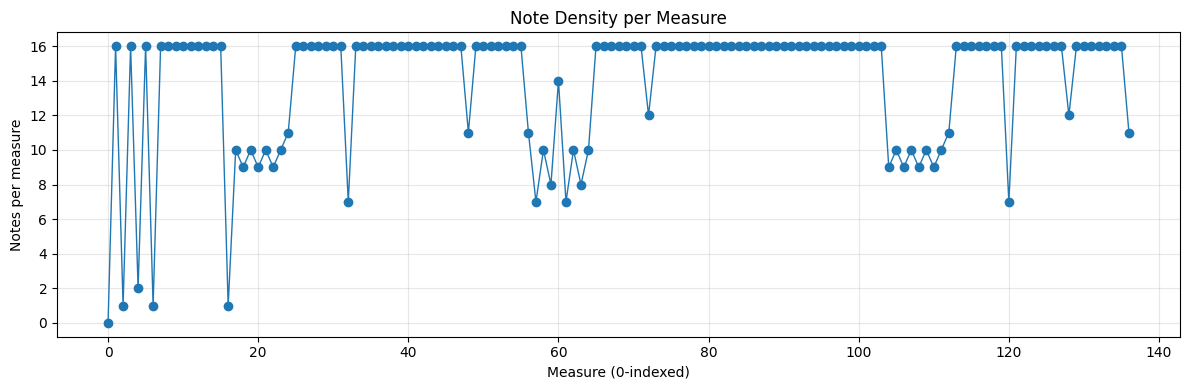

In [ ]:
from parser import parse_sm_chart

chart_path = PROJECT_ROOT / "data/raw/Stamina RPG 6/[19] lovism/lovism.sm"
densities = parse_sm_chart(chart_path)

print(f"Loaded {len(densities)} measures from {chart_path.name}")

plt.figure(figsize=(12, 4))
plt.plot(range(len(densities)), densities, marker="o", linewidth=1)
plt.title("Note Density per Measure")
plt.xlabel("Measure (0-indexed)")
plt.ylabel("Notes per measure")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Visualización mas fiel a lo que se vería en el juego:

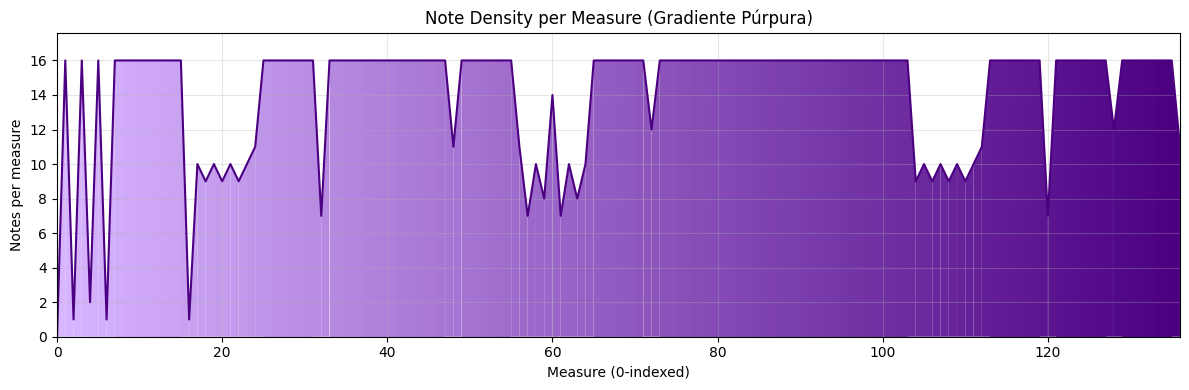

In [ ]:
x = np.arange(len(densities))
y = np.array(densities)

fig, ax = plt.subplots(figsize=(12, 4))

# Línea principal sin marcadores
ax.plot(x, y, linewidth=1.5, color="#4b0082")

# Gradiente púrpura bajo la curva
cmap = LinearSegmentedColormap.from_list("purple_grad", ["#d8b5ff", "#4b0082"])
colors = cmap(np.linspace(0, 1, len(x) - 1))

verts = [
    [(x[i], 0), (x[i], y[i]), (x[i + 1], y[i + 1]), (x[i + 1], 0)]
    for i in range(len(x) - 1)
]
poly = PolyCollection(verts, facecolors=colors, edgecolors="none")
ax.add_collection(poly)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, y.max() * 1.1)
ax.set_title("Note Density per Measure (Fancy)")
ax.set_xlabel("Measure (0-indexed)")
ax.set_ylabel("Notes per measure")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Como se observa, la densidad de notas revela las secciones de mayor carga y los breaks; esto se usa para derivar secuencias de stream/break y métricas de evidencia.

In [5]:
from features import (
    calculate_breakdown_metrics,
    generate_breakdown_string,
    get_stream_sequences,
)

sequences = get_stream_sequences(densities, threshold=16)
breakdown_text = generate_breakdown_string(densities, threshold=16)
metrics = calculate_breakdown_metrics(densities)

sequences_pretty = [
    {"length": seg["length"], "is_break": seg["is_break"], "start": seg["start"], "end": seg["end"]}
    for seg in sequences
]

print("Stream/Break Sequences:")
pprint(sequences_pretty, sort_dicts=False)
print("\nBreakdown String:")
print(breakdown_text)
print("\nMetrics:")
pprint(metrics)


Stream/Break Sequences:
[{'length': 1, 'is_break': False, 'start': 1, 'end': 1},
 {'length': 1, 'is_break': False, 'start': 3, 'end': 3},
 {'length': 1, 'is_break': False, 'start': 5, 'end': 5},
 {'length': 9, 'is_break': False, 'start': 7, 'end': 15},
 {'length': 9, 'is_break': True, 'start': 16, 'end': 24},
 {'length': 7, 'is_break': False, 'start': 25, 'end': 31},
 {'length': 15, 'is_break': False, 'start': 33, 'end': 47},
 {'length': 7, 'is_break': False, 'start': 49, 'end': 55},
 {'length': 9, 'is_break': True, 'start': 56, 'end': 64},
 {'length': 7, 'is_break': False, 'start': 65, 'end': 71},
 {'length': 31, 'is_break': False, 'start': 73, 'end': 103},
 {'length': 9, 'is_break': True, 'start': 104, 'end': 112},
 {'length': 7, 'is_break': False, 'start': 113, 'end': 119},
 {'length': 7, 'is_break': False, 'start': 121, 'end': 127},
 {'length': 7, 'is_break': False, 'start': 129, 'end': 135}]

Breakdown String:
1 1 1 9 (9) 7 15 7 (9) 7 31 (9) 7 7 7

Metrics:
{'average_nps': 13.9781

In [6]:
print("--- ANALYSIS RESULT ---")
print(f"File: {chart_path.name}")
print(f"Calculated Breakdown: {breakdown_text}")

print("\nMetrics:")
print(f"- Total Stream: {metrics['total_stream_length']}")
print(f"- Max Stream: {metrics['max_stream_length']}")
print(f"- Break Count: {metrics['break_count']}")
print(f"- Stream/Break Ratio: {metrics['stream_break_ratio']:.3f}")
print(f"- Average NPS: {metrics['average_nps']:.3f}")


--- ANALYSIS RESULT ---
File: lovism.sm
Calculated Breakdown: 1 1 1 9 (9) 7 15 7 (9) 7 31 (9) 7 7 7

Metrics:
- Total Stream: 100
- Max Stream: 31
- Break Count: 3
- Stream/Break Ratio: 3.704
- Average NPS: 13.978
